In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 05b Toy Dataset Benchmarker
> Run a given model on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05b Toy Dataset Benchmarker.ipynb"
dataset_name = "directed circle"
sigma = "automatic"
flow_strength = 1
smoothness_weight = 0
flow_neighbor_loss_weight = 0
contrastive_flow_loss_weight = 0
contrastive_loss_weight = 1
reconstruction_loss_weight = 0
diffdist_weight = 10
prior_embedding = "UMAP"
num_neighbors = 5

# Set Up

Computing UMAP


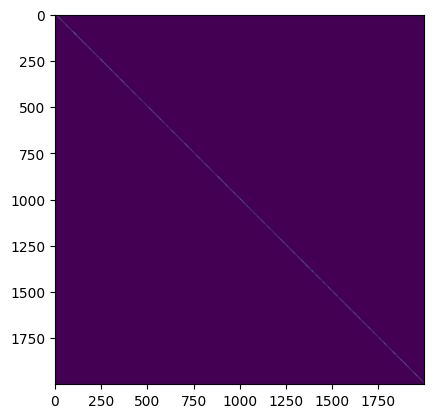

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, directed_circle, line_with_discontinuities
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorFieldV2
from torch.utils.data import DataLoader
from FRED.data_processing import ManifoldWithVectorField, ManifoldWithVectorFieldV2, FRED_collate
# choose correct dataset
num_nodes = 2000
if dataset_name == "double helix":
    X, flow, labels = double_helix(num_nodes=num_nodes)
elif dataset_name == "noisy double helix":
    X, flow, labels = double_helix(num_nodes=num_nodes, noise=1)
elif dataset_name == "branch":
    X, flow, labels = directed_sinh_branch(num_nodes=num_nodes)
elif dataset_name == "directed circle":
    X, flow, labels = directed_circle(num_nodes=num_nodes)
elif dataset_name == "discontinuous line":
    X, flow, labels = line_with_discontinuities(num_nodes=num_nodes)
else:
    raise NotImplementedError
# build dataset
from torch.utils.data import DataLoader
from functools import partial
ds = ManifoldWithVectorFieldV2(X, flow, labels, prior_embedding=prior_embedding)
FRED_collate_with_dists = partial(FRED_collate,precomputed_distances = ds.precomputed_distances)
dataloader = DataLoader(ds, batch_size=64, shuffle=True, collate_fn=FRED_collate_with_dists)

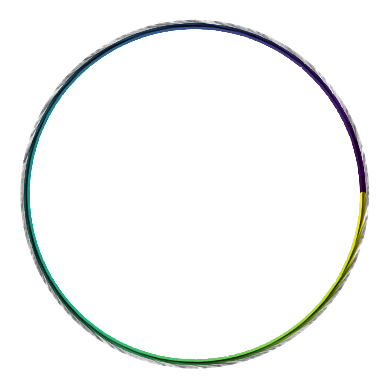

In [ ]:
# visualize figure
from FRED.datasets import plot_origin_3d, plot_directed_2d
# if figure is 3d or 2d
if np.sum(np.abs(X[:,2])) == 0:
    plot_directed_2d(X,flow,labels,minimal=True)
else:
    mask_prob = 1
    num_nodes = X.shape[0]
    alpha_points, alpha_arrows = (0.1, 1) if labels is None else (1, 0.1)
    mask = np.random.rand(num_nodes) > mask_prob
    fig = plt.figure(dpi=400, figsize=(8,8))
    ax = fig.add_subplot(projection="3d",)
    plot_origin_3d(
        ax,
        xlim=[X[:, 0].min(), X[:, 0].max()],
        ylim=[X[:, 1].min(), X[:, 1].max()],
        zlim=[X[:, 2].min(), X[:, 2].max()],
        )
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker=".", c=labels, cmap="viridis", alpha=alpha_points)
    ax.quiver(
        X[mask, 0],
        X[mask, 1],
        X[mask, 2],
        flow[mask, 0],
        flow[mask, 1],
        flow[mask, 2],
        alpha=0.4,
        length=0.4,
        normalize=False,
    )
# ax.axis('off')
# ax.grid(False)
# lim = np.max(np.linalg.norm(X, axis=1))
# print("lim is",lim)
# ax.axes.set_xlim3d(left=-lim, right=lim)
# ax.axes.set_ylim3d(bottom=-lim, top=lim)
# ax.axes.set_zlim3d(bottom=-lim, top=lim)
plt.show()

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[X.shape[1], 20, 10, 5, 2],
            device=device,
            sigma=5,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "distance regularization": diffdist_weight,
            "smoothness": 0,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive loss v2": contrastive_loss_weight,
        }
print("using loss weights ",loss_weights)
visualization_functions = [
    visualize_points,
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(
    FE = MFE, 
    loss_weights=loss_weights, 
    visualization_functions = visualization_functions, 
    device=device, 
    title = title,
    data_type="Contrastive Flow",
    learning_rate=1e-3
    )

using loss weights  {'distance regularization': 10, 'smoothness': 0, 'flow neighbor loss': 0, 'contrastive loss v2': 1}


  0%|          | 0/500 [00:00<?, ?it/s]

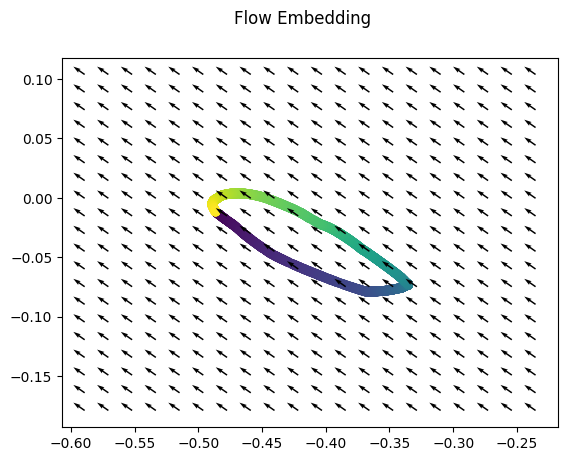

  2%|▏         | 10/500 [00:25<34:33,  4.23s/it]

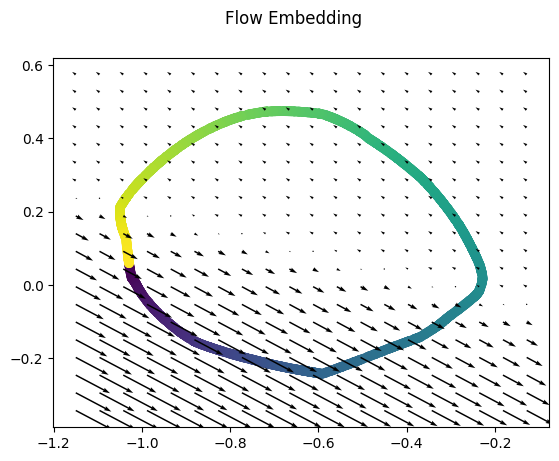

  4%|▍         | 20/500 [00:33<07:22,  1.08it/s]

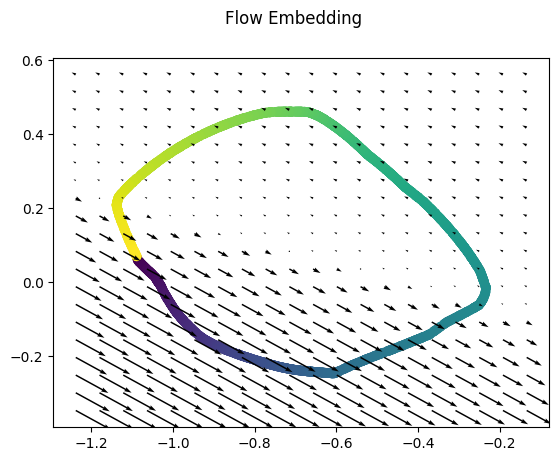

  6%|▌         | 30/500 [00:46<08:53,  1.14s/it]

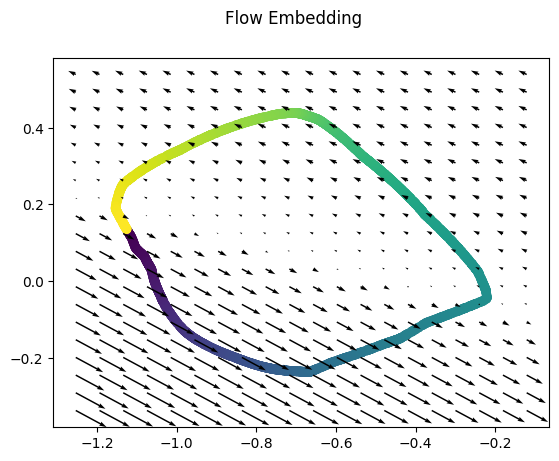

  8%|▊         | 40/500 [00:55<06:40,  1.15it/s]

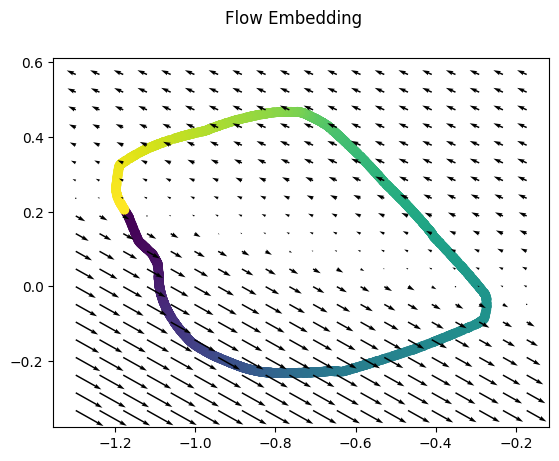

 10%|█         | 50/500 [01:04<06:27,  1.16it/s]

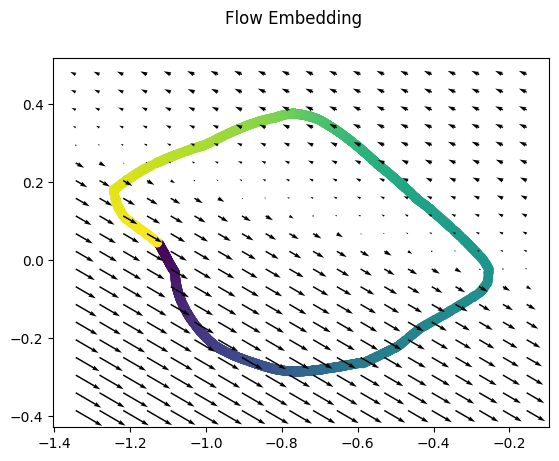

 12%|█▏        | 60/500 [01:12<06:05,  1.21it/s]

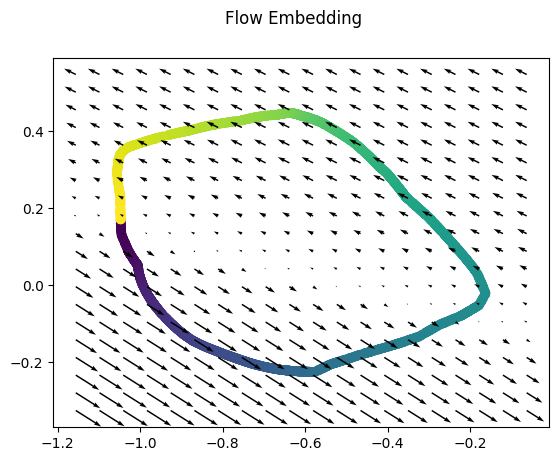

 14%|█▍        | 70/500 [01:20<05:51,  1.22it/s]

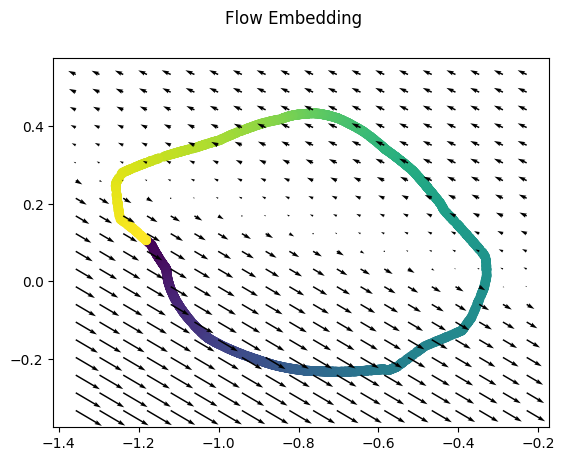

 16%|█▌        | 80/500 [01:35<08:52,  1.27s/it]

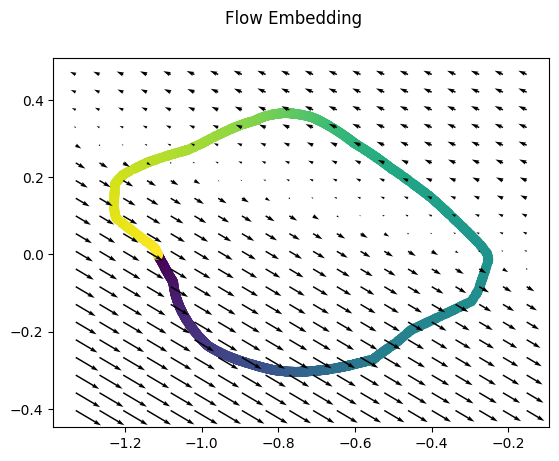

 18%|█▊        | 90/500 [01:49<18:13,  2.67s/it]

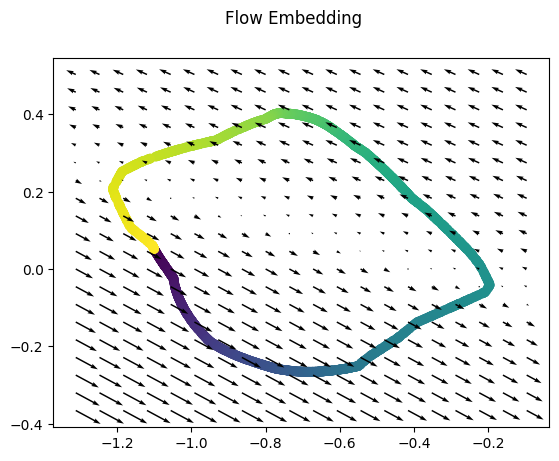

 20%|██        | 100/500 [02:15<25:22,  3.81s/it]

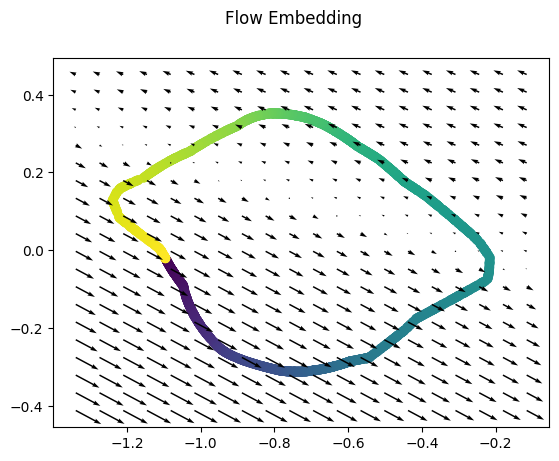

 22%|██▏       | 110/500 [02:29<09:03,  1.39s/it]

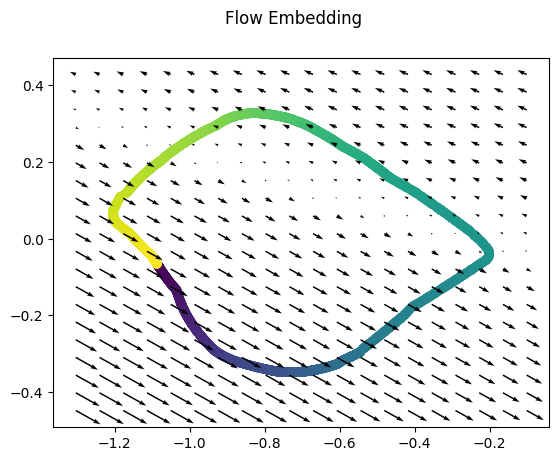

 24%|██▍       | 120/500 [02:47<07:46,  1.23s/it]

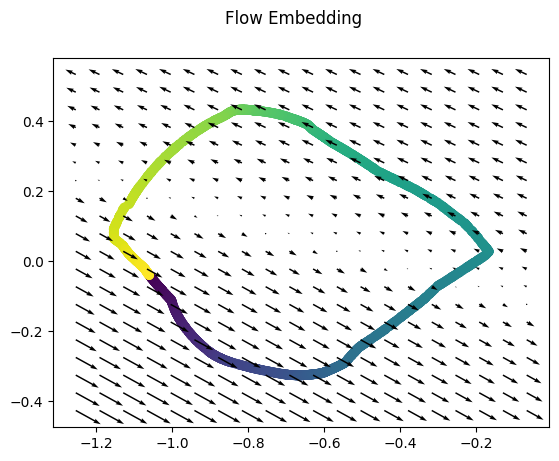

 26%|██▌       | 130/500 [03:01<05:35,  1.10it/s]

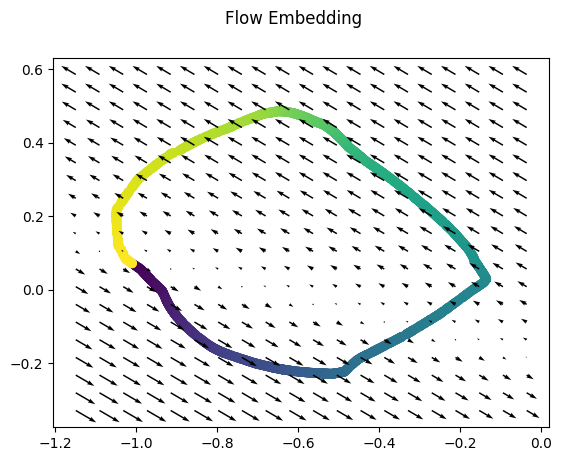

 28%|██▊       | 140/500 [03:09<04:39,  1.29it/s]

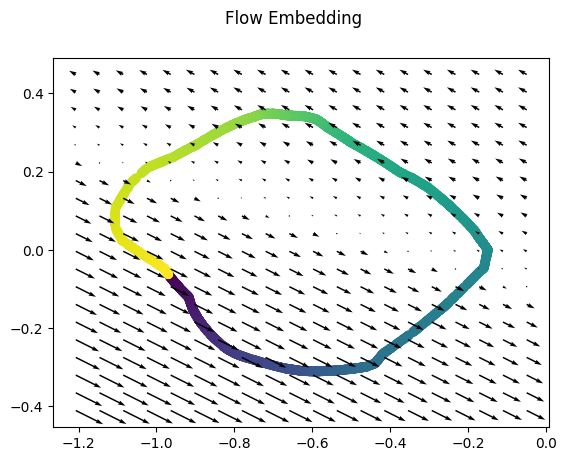

 30%|███       | 150/500 [03:17<04:36,  1.27it/s]

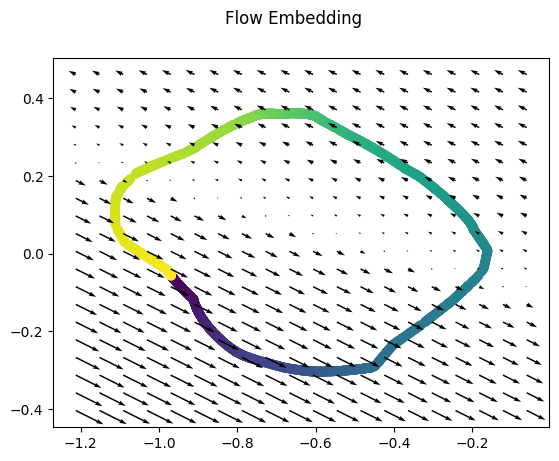

 32%|███▏      | 160/500 [03:25<04:17,  1.32it/s]

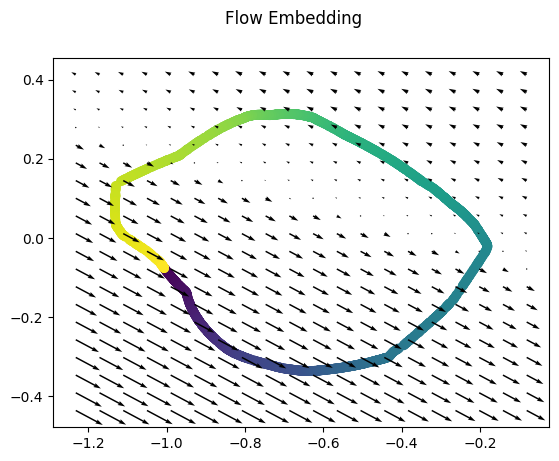

 34%|███▍      | 170/500 [03:32<04:16,  1.29it/s]

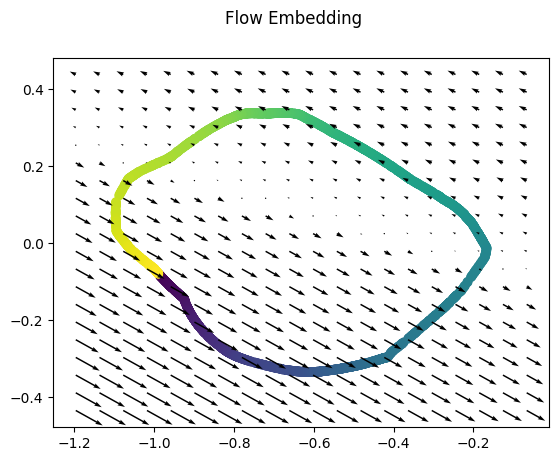

 36%|███▌      | 180/500 [03:40<04:01,  1.32it/s]

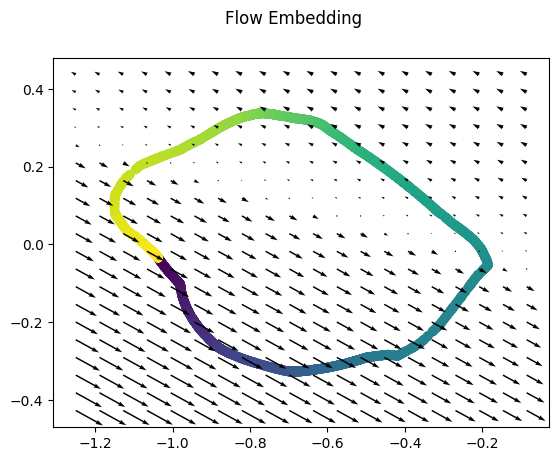

 38%|███▊      | 190/500 [03:48<04:07,  1.25it/s]

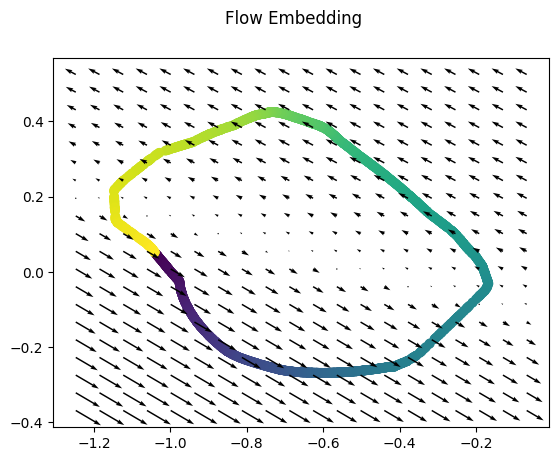

 40%|████      | 200/500 [03:56<03:50,  1.30it/s]

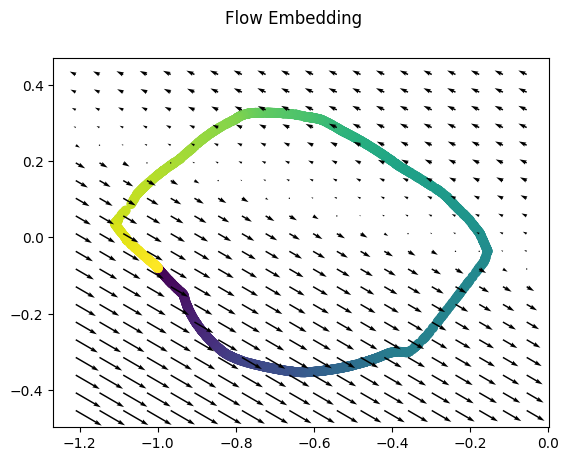

 42%|████▏     | 210/500 [04:10<05:02,  1.04s/it]

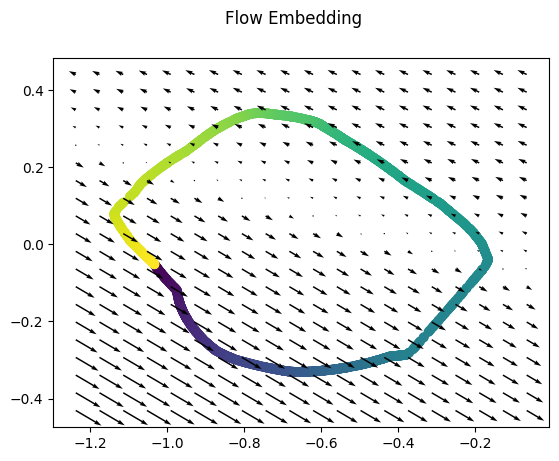

 44%|████▍     | 220/500 [04:19<03:57,  1.18it/s]

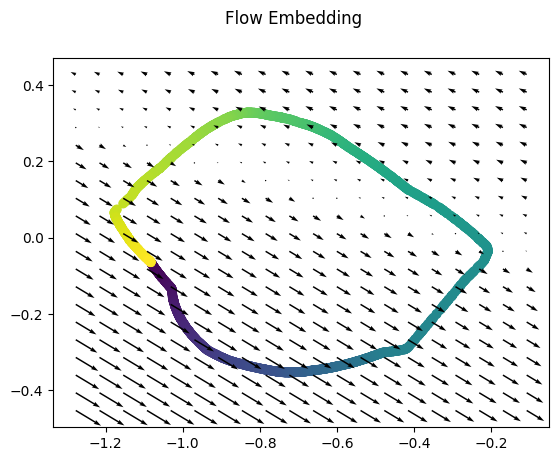

 46%|████▌     | 229/500 [04:26<03:47,  1.19it/s]

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=500)

# Results

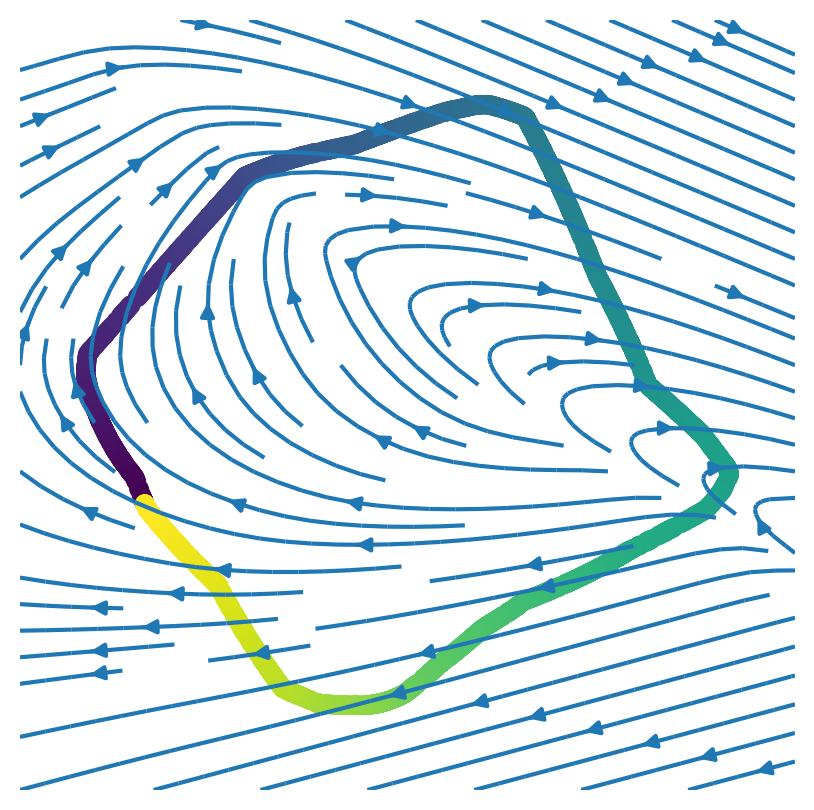

In [ ]:
FREDtrainer.visualize_embedding(use_streamlines=True)

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()
flow_artist = FREDtrainer.flow_artist

In [ ]:
# from FRED import embed
# from FRED.trainers import visualize_points
# visualize_points(FREDtrainer.embedded_points.cpu().detach(), FREDtrainer.flow_artist, labels = labels, use_streamlines=True)

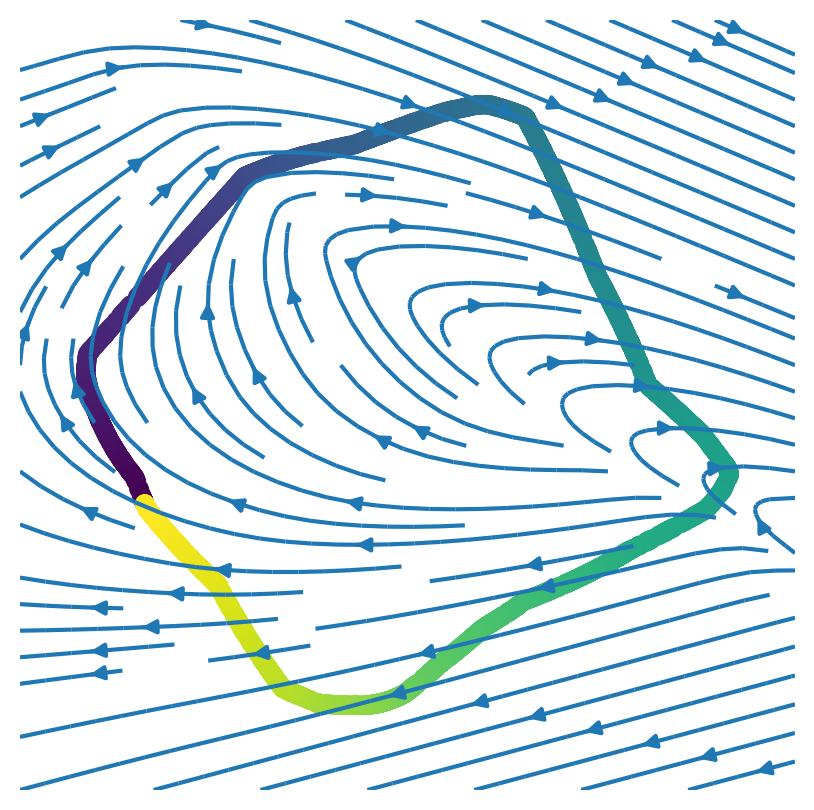

In [ ]:
from FRED.embed import compute_grid
fig = plt.figure(dpi=200, figsize=(5,5))
ax = fig.add_subplot()
grid_width = 100
minx = float(np.min(embedded_points[:, 0]) - 0.1)  # TODO: use torch.min, try without detach
maxx = float(np.max(embedded_points[:, 0]) + 0.1)
miny = float(np.min(embedded_points[:, 1]) - 0.1)
maxy = float(np.max(embedded_points[:, 1]) + 0.1)
x = np.linspace(minx, maxx, grid_width)
y = np.linspace(miny, maxy, grid_width)
# build grid points
Xgrid, Ygrid = np.meshgrid(x, y)
xy_t = torch.concat([torch.tensor(Xgrid[:,:,None]), torch.tensor(Ygrid[:, :, None])], dim=2).float()
# xy_t = xy_t.reshape(grid_width**2, 2).detach()
# pass grid through flow artist
uv = flow_artist(xy_t).detach().cpu()
u = uv[:,:, 0].cpu()
v = uv[:,:, 1].cpu()
sc = ax.scatter(
    embedded_points[:, 0],
    embedded_points[:, 1],
    c=labels, cmap='viridis'
)
ax.streamplot(x,y,u,v)
plt.axis("off")
# Display all open figures.
plt.show()
plt.close()

In [ ]:
X.shape

(2000, 3)

In [ ]:
from FRED.embed import compute_grid
import plotly.figure_factory as ff
import numpy as np
import plotly.graph_objects as go
grid_width=200
# grid, x, y = compute_grid(embedded_points.to(device), return_unmeshed_x_and_y=True, grid_width=100)
minx = float(np.min(X[:, 0]) - 0.1)  # TODO: use torch.min, try without detach
maxx = float(np.max(X[:, 0]) + 0.1)
miny = float(np.min(X[:, 1]) - 0.1)
maxy = float(np.max(X[:, 1]) + 0.1)
x = np.linspace(-minx, maxx, grid_width)
y = np.linspace(-miny, maxy, grid_width)
X, Y = np.meshgrid(x, y)
xy_t = torch.concat([torch.tensor(X[:,:,None]), torch.tensor(Y[:, :, None])], dim=2).float()
# xy_t = xy_t.reshape(grid_width**2, 2).detach()
# controls the x and y axes of the plot
# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
# u = -1 - grid[:,0]**2 + grid[:,1]
# v = 1 + grid[:,0] - grid[:,1]**2
# u = -1 - X**2 + Y
# v = 1 + X - Y**2
uv = flow_artist(xy_t).detach().cpu()
u = uv[:,:, 0].cpu().numpy()
v = uv[:,:, 1].cpu().numpy()
# x = x.numpy()
# y = y.numpy()
# u = u.numpy()
# v = v.numpy()

In [ ]:
uv[:,:,0]

tensor([[37.0991, 37.0991, 37.0991,  ..., 37.0991, 37.0991, 37.0991],
        [37.0991, 37.0991, 37.0991,  ..., 37.0991, 37.0991, 37.0991],
        [37.0991, 37.0991, 37.0991,  ..., 37.0991, 37.0991, 37.0991],
        ...,
        [37.0990, 37.0990, 37.0990,  ..., 37.0990, 37.0990, 37.0990],
        [37.0990, 37.0990, 37.0990,  ..., 37.0990, 37.0990, 37.0990],
        [37.0990, 37.0990, 37.0990,  ..., 37.0990, 37.0990, 37.0990]])

In [ ]:
v

array([[-12.608124, -12.608124, -12.608124, ..., -12.608124, -12.608124,
        -12.608124],
       [-12.608124, -12.608124, -12.608124, ..., -12.608124, -12.608124,
        -12.608124],
       [-12.608124, -12.608124, -12.608124, ..., -12.608122, -12.608122,
        -12.608122],
       ...,
       [-12.608067, -12.608067, -12.608067, ..., -12.608067, -12.608067,
        -12.608067],
       [-12.608067, -12.608067, -12.608067, ..., -12.608067, -12.608067,
        -12.608067],
       [-12.608067, -12.608067, -12.608067, ..., -12.608067, -12.608067,
        -12.608067]], dtype=float32)

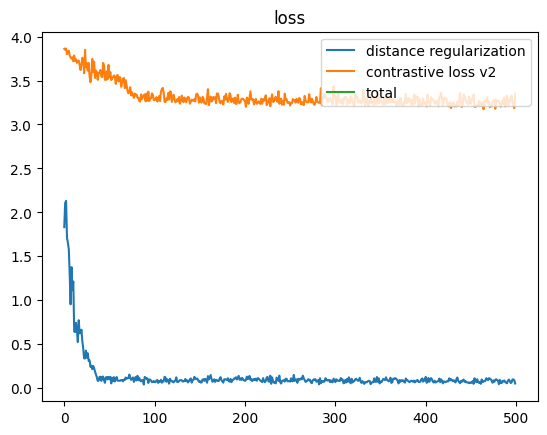

In [ ]:
FREDtrainer.visualize_loss(loss_type='all')

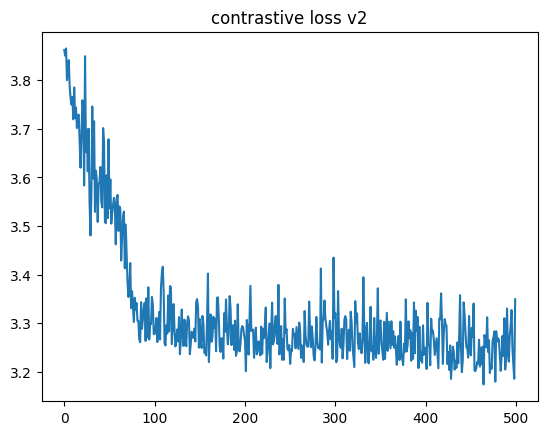

In [ ]:
FREDtrainer.visualize_loss(loss_type='contrastive loss v2')

In [ ]:
FREDtrainer.training_gif(duration=150)

HTML(value='<img src="data:image/gif;base64,R0lGODlhgALgAYcAAP///////f//+///+P//6v7///z///7//Pz//P3/9fr///f///…

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()
points_and_flows = np.concatenate([embedded_points, embedded_velocities], axis=1)
points_and_flows.shape

(2000, 4)

In [ ]:
import sklearn 
silhouette_points = sklearn.metrics.silhouette_score(embedded_points, labels)
silhouette_points_and_flows = sklearn.metrics.silhouette_score(points_and_flows, labels)

ValueError: Number of labels is 2000. Valid values are 2 to n_samples - 1 (inclusive)

## Nearest Neighbors Classifier Score

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(points_and_flows, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighClass = KNeighborsClassifier(n_neighbors=3)
neighClass.fit(X_train, y_train)
knn_classifier_score = neighClass.score(X_test, y_test)

In [ ]:
print(f"## SCORES ## \n silhouette score w/o flows: {silhouette_points}.\n silhouette score w/ flows:  {silhouette_points_and_flows} \n kNN Classifier {knn_classifier_score}")

## SCORES ## 
 silhouette score w/o flows: 0.6303980350494385.
 silhouette score w/ flows:  0.744752824306488 
 kNN Classifier 1.0


# Write results to spreadsheet

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
unid

'1Izng5TBE5fzUF21WwyJ'

In [ ]:
import csv
spread_name = notebook
with open(f"{spread_name}.csv", 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(
        [unid, 
         sigma, 
         flow_strength, 
         flow_neighbor_loss_weight,
         smoothness_weight, 
         diffdist_weight, 
         silhouette_points,
         silhouette_points_and_flows,
         knn_classifier_score
        ]) 

# UMAP and PHATE on the dataset

In [ ]:
X, flow, labels = double_helix(num_nodes=num_nodes, noise=1)

In [ ]:
import umap
reducer = umap.UMAP()
umap_coords = reducer.fit_transform(X)

<matplotlib.collections.PathCollection>

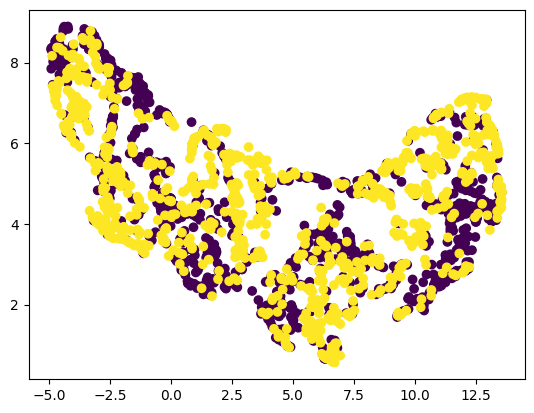

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(umap_coords[:,0],umap_coords[:,1],c=labels)

In [ ]:
import phate
phate_op = phate.PHATE()
phate_coords = phate_op.fit_transform(X)

Calculating PHATE...
  Running PHATE on 2000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 10.01 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.59 seconds.
Calculated PHATE in 17.88 seconds.


<matplotlib.collections.PathCollection>

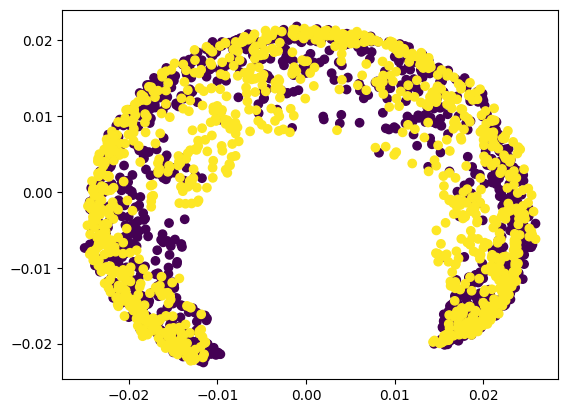

In [ ]:
plt.scatter(phate_coords[:,0],phate_coords[:,1],c=labels)